In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

normal_data_path = r"/root/user/j0114690/EGT/normal_features_5_light.csv"
abnormal_data_path = r"/root/user/j0114690/EGT/anormal_features_5_light.csv"

normal_data = pd.read_csv(normal_data_path)
abnormal_data = pd.read_csv(abnormal_data_path)

num_normal = normal_data.shape[0]
num_abnormal = abnormal_data.shape[0]
total_samples = num_normal + num_abnormal

print(f"正常サンプル数: {num_normal}")
print(f"異常サンプル数: {num_abnormal}")
print(f"合計サンプル数: {total_samples}")
print(f"正常サンプル/異常サンプル: {num_normal/num_abnormal}")

正常サンプル数: 340810
異常サンプル数: 224
合計サンプル数: 341034
正常サンプル/異常サンプル: 1521.4732142857142


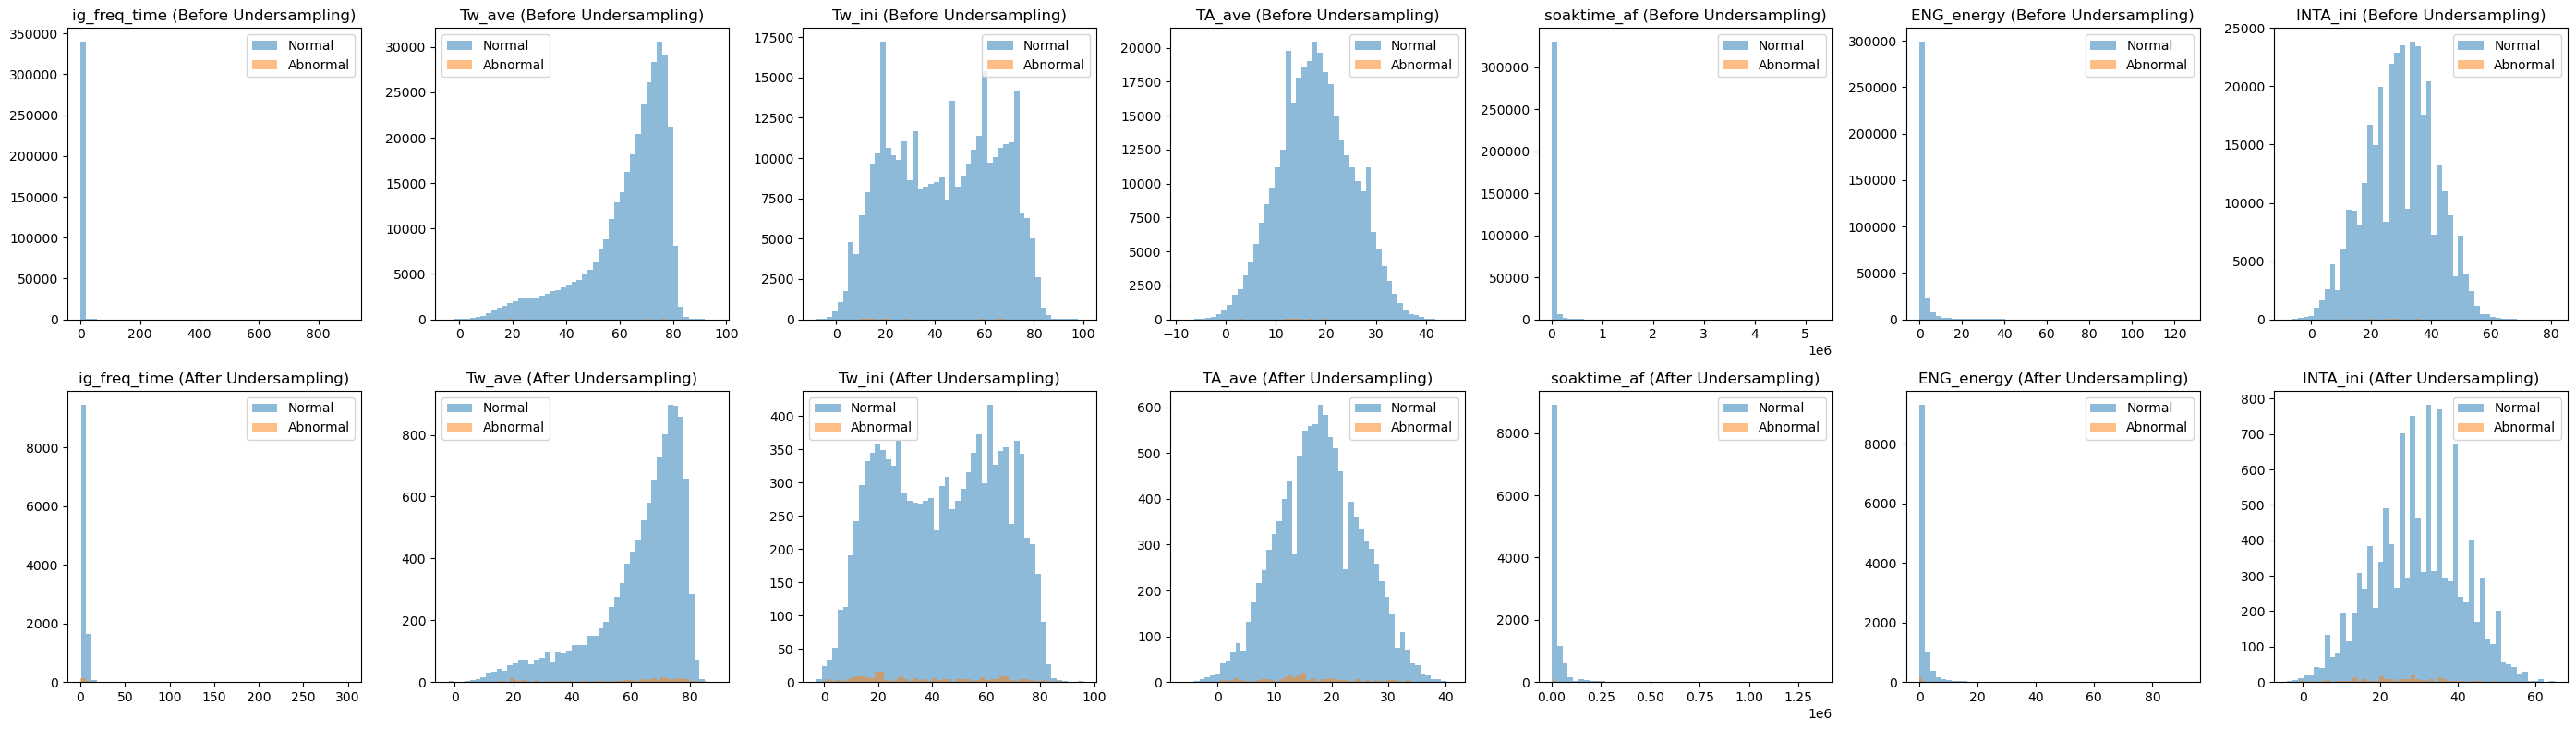

In [21]:
normal_data['label'] = 0
abnormal_data['label'] = 1
df = pd.concat([normal_data, abnormal_data], ignore_index=True)

# SRS(層化ランダムアンダーサンプリング)を実施する特徴量ラベルリスト
stratify_features = ['ig_freq_time', 'Tw_ave', 'Tw_ini', 'TA_ave', 'soaktime_af','ENG_energy', 'INTA_ini',] 

#設定値
ratio = 20
split_group =100
bin = 50
#sample<1000,split_group = 5~10
#sample<10000,split_group = 10~50
#sample>10000,split_group = 50~100
#sample>100000,split_group = 50~200


# 指定された特徴量ラベルに対して、層化ランダムアンダーサンプリングを実施する前後のヒストグラム分布を表示
num_features = len(stratify_features)
num_before_rows = (num_features + 6) // 7
num_after_rows = (num_features + 6) // 7
num_rows = num_before_rows + num_after_rows
fig, axs = plt.subplots(num_rows, 7, figsize=(28, 4*num_rows))
axs = axs.flatten()

for i, feature in enumerate(stratify_features):
    row = i // 7
    col = i % 7
    
    axs[row*7+col].hist(df[df['label'] == 0][feature], bins=bin, alpha=0.5, label='Normal')
    axs[row*7+col].hist(df[df['label'] == 1][feature], bins=bin, alpha=0.5, label='Abnormal')
    axs[row*7+col].set_title(f'{feature} (Before Undersampling)')
    axs[row*7+col].legend()

for i, feature in enumerate(stratify_features):
    row = num_before_rows + i // 7
    col = i % 7
    
    normal_samples_undersampled, _ = train_test_split(df[df['label'] == 0], train_size=ratio*len(abnormal_data), stratify=pd.qcut(df[df['label'] == 0][feature], split_group, duplicates='drop'))
    df_undersampled = pd.concat([normal_samples_undersampled, df[df['label'] == 1]])

    axs[row*7+col].hist(df_undersampled[df_undersampled['label'] == 0][feature], bins=bin, alpha=0.5, label='Normal')
    axs[row*7+col].hist(df_undersampled[df_undersampled['label'] == 1][feature], bins=bin, alpha=0.5, label='Abnormal')
    axs[row*7+col].set_title(f'{feature} (After Undersampling)')
    axs[row*7+col].legend()

# 使用しないaxsを削除
for i in range(num_rows):
    for j in range(7):
        if (i < num_before_rows and i*7+j >= num_features) or (i >= num_before_rows and (i-num_before_rows)*7+j >= num_features):
            fig.delaxes(axs[i*7+j])

plt.tight_layout()
plt.show()

In [22]:
# 出力観点の指定
output_feature = 'TA_ave'

In [23]:
# 指定されたラベル,正常データでSRS
normal_samples_undersampled, _ = train_test_split(df[df['label'] == 0], train_size=ratio*len(abnormal_data), stratify=pd.qcut(df[df['label'] == 0][output_feature], split_group, duplicates='drop'))

# SRS出力
output_filename = f"{os.path.splitext(os.path.basename(normal_data_path))[0]}_srs{ratio}.csv"
output_path = os.path.join(os.path.dirname(normal_data_path), output_filename)
normal_samples_undersampled.drop('label', axis=1).to_csv(output_path, index=False)